In [1]:
import os
os.chdir('../../../')

import pandas as pd
import numpy as np
import pickle

from lsmm_data import LSMMData
import json

with open('data/assembly/pyr_rect.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings

Filtering to pyramidal cells only
459


c:\Users\trevo\anaconda3\envs\analysis\Lib\site-packages\lsmm_data\LSMMData.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['structural']['post_cell']['connectome_index'] = data['structural']['post_cell'].index
c:\Users\trevo\anaconda3\envs\analysis\Lib\site-packages\lsmm_data\LSMMData.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['structural']['post_cell']['pt_position'] = [[data['structural']['post_cell'].iloc[i]['pt_position_x'],data['structural']['post_cell'].iloc[i]['pt_position

Generating Connectome...


100%|██████████| 44293/44293 [01:55<00:00, 383.17it/s]


Generating Connectome...


100%|██████████| 44293/44293 [01:53<00:00, 390.32it/s]


In [2]:
# Make a graph
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
post_cell_table = data_a['structural']['post_cell'].copy()
post_cell_table['connectome_index'] = post_cell_table.index

synapse_table = data_a['structural']['synapse']

assembly_to_root_ids = mappings_a['pt_root_ids_by_assembly']
assembly_root_ids_set = set(mappings_a['assemblies_by_pt_root_id'].keys())

# Filter synapses_table to only synapses between two assembly cells (including No A)
synapses_df = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]
synapses_df = synapses_df[synapses_df['post_pt_root_id'].isin(assembly_root_ids_set)]

# Filter cell tables to only assembly cells
cell_table = cell_table[cell_table['pt_root_id'].isin(assembly_root_ids_set)]
post_cell_table = post_cell_table[post_cell_table['pt_root_id'].isin(assembly_root_ids_set)]

pre_root_ids = set(cell_table['pt_root_id'].values)
post_root_ids = set(post_cell_table['pt_root_id'].values)
all_root_ids = pre_root_ids | post_root_ids

In [3]:
# Prep the sets

# Collect w, s, and b
w = {}
s = {}
b = {}

# collect each potential pre, post combination
for pre in pre_root_ids:
    for post in post_root_ids:
        if pre != post:
            w[(pre, post)] = 0
            s[(pre, post)] = 0
            b[(pre, post)] = 0

# from the synapse table, aggregate total summed PSD, synapse count, and binary presence of connectivity
for i, row in synapses_df.iterrows():
    pre = row['pre_pt_root_id']
    post = row['post_pt_root_id']
    w[(pre, post)] += row['size']
    s[(pre, post)] += 1
    b[(pre, post)] = 1

# Split out assemblies and no_a
assembly_names = set(assembly_to_root_ids.keys()) - set(['No A'])
A_invert = {assembly: set(assembly_to_root_ids[assembly]) for assembly in assembly_names}
no_A = set(assembly_to_root_ids['No A'])
A = {pt_root_id: set(mappings_a['assemblies_by_pt_root_id'][pt_root_id]) for pt_root_id in all_root_ids if 'No A' not in mappings_a['assemblies_by_pt_root_id'][pt_root_id]}

# C functions
def shared(pre, post, A):
    try:
        return not A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def disjoint(pre, post, A):
    try:
        return A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def shared_no_a(pre, post, A):
    return (pre in no_A) and (post in no_A)
    
def no_a_a(pre, post, A):
    return (pre in no_A) and (post not in no_A)

def a_no_a(pre, post, A):
    return (pre not in no_A) and (post in no_A)

C = [shared, disjoint, shared_no_a, no_a_a, a_no_a]

## Pairwise Set Creation

In [4]:
# Calculate the pairwise binary connectivity and summed PSD sets

W_nonzero_pair = {}
B_pair = {}
for c in C:
    W_nonzero_pair[c.__name__] = {}
    B_pair[c.__name__] = {}
    for (j, i) in w.keys():
        if c(j, i, A):
            B_pair[c.__name__][(j, i)] = 1 if w[(j, i)] > 0 else 0
            if w[(j, i)] > 0:
                W_nonzero_pair[c.__name__][(j, i)] = w[(j, i)]

## Inbound, Outbound Set Creation

In [5]:
# what if a pre-cell has connections in one C type but not the other? Only include those with both? but then n decreases
# also note that there are no autapses in synapses_df, so even if we sum across all post-cells (including post-cell = pre-cell), still okay
W_nonzero_out = {}
for c in C:
    W_nonzero_out[c.__name__] = {}
    for j in pre_root_ids:
        if len([i for i in post_root_ids if i != j and c(j, i, A) and w[j, i] > 0]) > 0:
            W_nonzero_out[c.__name__][j] = sum([w[(j, i)] for i in post_root_ids if c(j, i, A) and j != i]) / len([i for i in post_root_ids if i != j and c(j, i, A) and w[j, i] > 0])

# calculate set of differences between paired cells for the shared, disjoint groups (only including those in both sets)
shared_cells = set(W_nonzero_out.get('shared', {}).keys())
disjoint_cells = set(W_nonzero_out.get('disjoint', {}).keys())
common_cells = shared_cells & disjoint_cells

W_nonzero_out_paired = [W_nonzero_out['shared'][j] - W_nonzero_out['disjoint'][j] for j in common_cells]

W_nonzero_in = {}
for c in C:
    W_nonzero_in[c.__name__] = {}
    for i in post_root_ids:
        if len([j for j in pre_root_ids if c(j, i, A)]) > 0 and len([j for j in pre_root_ids if j != i and c(j, i, A) and w[j,i] > 0]):
            W_nonzero_in[c.__name__][i] = sum([w[(j, i)] for j in pre_root_ids if c(j, i, A) and i != j]) / len([j for j in pre_root_ids if j != i and c(j, i, A) and w[j,i] > 0])

# calculate set of differences between paired cells for the shared, disjoint groups (only including those in both sets)
shared_cells = set(W_nonzero_in.get('shared', {}).keys())
disjoint_cells = set(W_nonzero_in.get('disjoint', {}).keys())
common_cells = shared_cells & disjoint_cells

W_nonzero_in_paired = [W_nonzero_in['shared'][i] - W_nonzero_in['disjoint'][i] for i in common_cells]

B_out = {}
for c in C:
    B_out[c.__name__] = {}
    for j in pre_root_ids:
        if len([i for i in post_root_ids if c(j, i, A) and j != i]) > 0:
            B_out[c.__name__][j] = sum([b[(j, i)] for i in post_root_ids if c(j, i, A) and j != i]) / len([i for i in post_root_ids if c(j, i, A) and j != i])

B_in = {}
for c in C:
    B_in[c.__name__] = {}
    for i in post_root_ids:
        if len([j for j in pre_root_ids if c(j, i, A) and i != j]) > 0:
            B_in[c.__name__][i] = sum([b[(j, i)] for j in pre_root_ids if c(j, i, A) and i != j]) / len([j for j in pre_root_ids if c(j, i, A) and j != i])

# Pairwise

## Nonzero Sum PSD

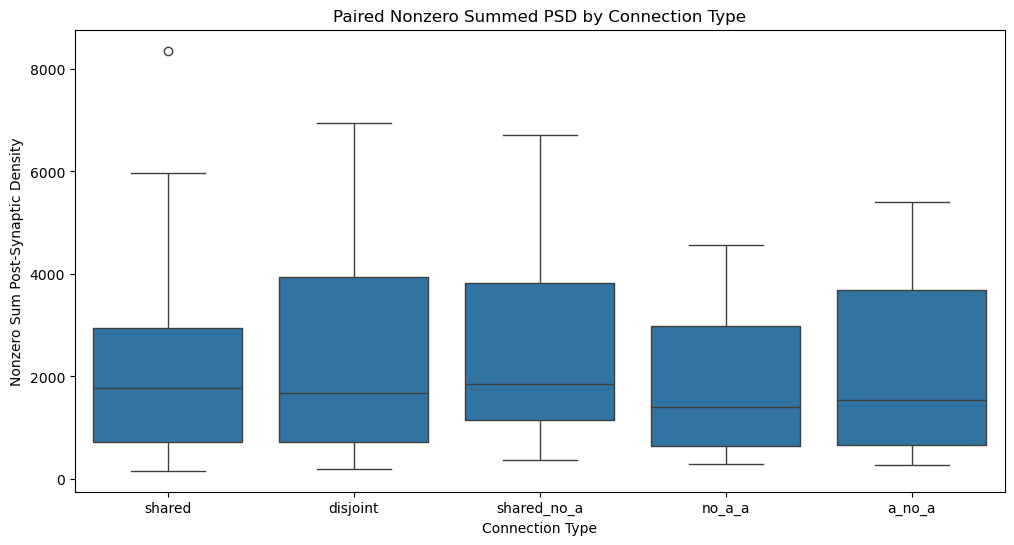

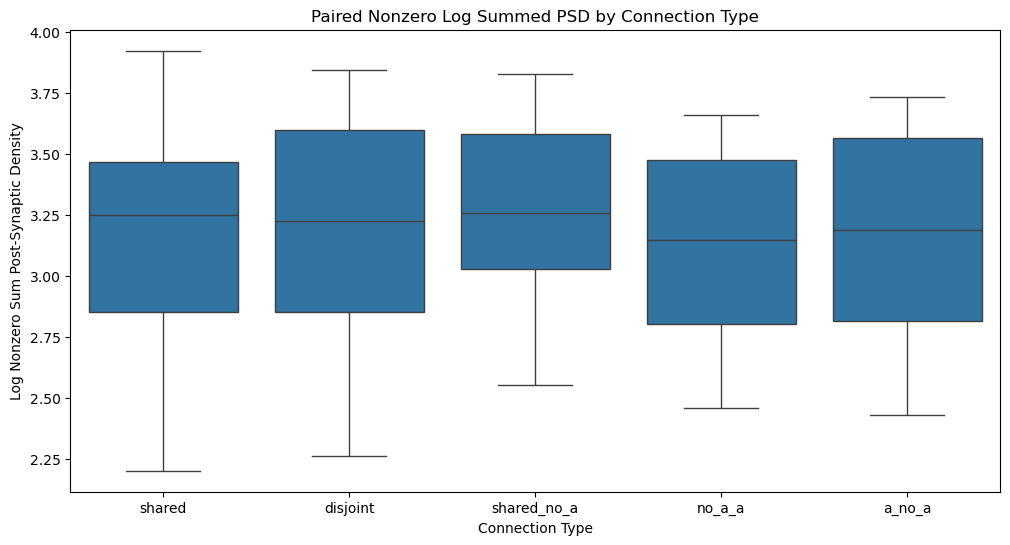

Normality Test Results (Shapiro-Wilk) with Sample Sizes:
             Sample Size  Statistic   p-value
shared              38.0   0.964007  0.255575
disjoint            56.0   0.945862  0.013941
shared_no_a          8.0   0.951174  0.723067
no_a_a              21.0   0.922390  0.096876
a_no_a              20.0   0.904785  0.050746

Kruskal-Wallis Test on Raw Data
Statistic: 0.8820, p-value: 0.9271

ANOVA on Log-Transformed Data
             sum_sq     df         F    PR(>F)
Group      0.134793    4.0  0.181098  0.947868
Residual  25.678672  138.0       NaN       NaN


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols

data = []
for group, values in W_nonzero_pair.items():
    for value in values.values():
        data.append({'Group': group, 'Value': value})

# Creation of dataframe
W_nonzero_pair_df = pd.DataFrame(data)

# Raw values boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=W_nonzero_pair_df, x='Group', y='Value')
plt.title('Paired Nonzero Summed PSD by Connection Type')
plt.xlabel('Connection Type')
plt.ylabel('Nonzero Sum Post-Synaptic Density')
plt.show()

# Log transformed boxplots
W_nonzero_pair_df['Log_Value'] = np.log10(W_nonzero_pair_df['Value'])

plt.figure(figsize=(12, 6))
sns.boxplot(data=W_nonzero_pair_df, x='Group', y='Log_Value')
plt.title('Paired Nonzero Log Summed PSD by Connection Type')
plt.xlabel('Connection Type')
plt.ylabel('Log Nonzero Sum Post-Synaptic Density')
plt.show()

# shapiro test for each group deviation from normality

normality_results = {}

for group in W_nonzero_pair_df['Group'].unique():
    group_values = W_nonzero_pair_df[W_nonzero_pair_df['Group'] == group]['Log_Value']
    stat, p_value = shapiro(group_values)
    sample_size = len(group_values)
    normality_results[group] = {'Sample Size': sample_size, 'Statistic': stat, 'p-value': p_value}

normality_results_df = pd.DataFrame(normality_results).T
print("Normality Test Results (Shapiro-Wilk) with Sample Sizes:")
print(normality_results_df)

print()

# KRUSKAL WALLIS
groups_raw = [list(W_nonzero_pair[group].values()) for group in W_nonzero_pair.keys()]
kruskal_stat, kruskal_p_value = kruskal(*groups_raw)
print("Kruskal-Wallis Test on Raw Data")
print(f"Statistic: {kruskal_stat:.4f}, p-value: {kruskal_p_value:.4f}")

# ANOVA on log-transformed data

model = ols('Log_Value ~ Group', data=W_nonzero_pair_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA on Log-Transformed Data")
print(anova_table)

Unable to Detect Any Significant Differences Between Groups

# Pairwise Probability of Connection

In [7]:
from scipy.stats import chi2_contingency

contingency_table = []

for group, connections in B_pair.items():
    connected_count = sum(connections.values())  # Count of 1s (connections)
    not_connected_count = len(connections) - connected_count  # Count of 0s (non-connections)
    contingency_table.append([connected_count, not_connected_count])

contingency_df = pd.DataFrame(contingency_table, index=B_pair.keys(), columns=['Connected', 'Not_Connected'])
print("Contingency Table:")
print(contingency_df)

# Step 2: Perform the Chi-Squared Test of Independence
chi2, p_value, dof, expected = chi2_contingency(contingency_df)
print("\nChi-Squared Test of Independence Results:")
print(f"Chi2 Statistic: {chi2:.4f}, p-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(pd.DataFrame(expected, index=contingency_df.index, columns=contingency_df.columns))

Contingency Table:
             Connected  Not_Connected
shared              38           1195
disjoint            56           2151
shared_no_a          8            376
no_a_a              21            951
a_no_a              20           1399

Chi-Squared Test of Independence Results:
Chi2 Statistic: 9.0774, p-value: 0.0592
Degrees of Freedom: 4
Expected Frequencies:
             Connected  Not_Connected
shared       28.369912    1204.630088
disjoint     50.780531    2156.219469
shared_no_a   8.835398     375.164602
no_a_a       22.364602     949.635398
a_no_a       32.649558    1386.350442


In [8]:
from itertools import combinations

pairwise_results = []

# Perform pairwise Chi-Squared tests between each group
for group1, group2 in combinations(B_pair.keys(), 2):
    # Get the connection data for each group
    connections1 = B_pair[group1]
    connections2 = B_pair[group2]
    
    # Count connected (1) and not connected (0) for each group
    connected_count1 = sum(connections1.values())
    not_connected_count1 = len(connections1) - connected_count1
    connected_count2 = sum(connections2.values())
    not_connected_count2 = len(connections2) - connected_count2
    
    # Create a contingency table for the pair
    contingency_table = [[connected_count1, not_connected_count1],
                         [connected_count2, not_connected_count2]]
    
    # Perform the Chi-Squared test for this pair
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Store the results
    pairwise_results.append({
        'Group 1': group1,
        'Group 2': group2,
        'Chi2 Statistic': chi2,
        'p-value': p_value,
        'Degrees of Freedom': dof
    })

# Convert results to a DataFrame for easy viewing
pairwise_results_df = pd.DataFrame(pairwise_results)
print("Pairwise Chi-Squared Test Results:")
print(pairwise_results_df)

Pairwise Chi-Squared Test Results:
       Group 1      Group 2  Chi2 Statistic   p-value  Degrees of Freedom
0       shared     disjoint        0.689524  0.406326                   1
1       shared  shared_no_a        0.726011  0.394179                   1
2       shared       no_a_a        1.435866  0.230809                   1
3       shared       a_no_a        7.862461  0.005047                   1
4     disjoint  shared_no_a        0.123163  0.725629                   1
5     disjoint       no_a_a        0.261767  0.608909                   1
6     disjoint       a_no_a        4.819211  0.028144                   1
7  shared_no_a       no_a_a        0.000000  1.000000                   1
8  shared_no_a       a_no_a        0.511025  0.474696                   1
9       no_a_a       a_no_a        1.510783  0.219020                   1


# By Cell Nonzero sum PSD

## Outbound

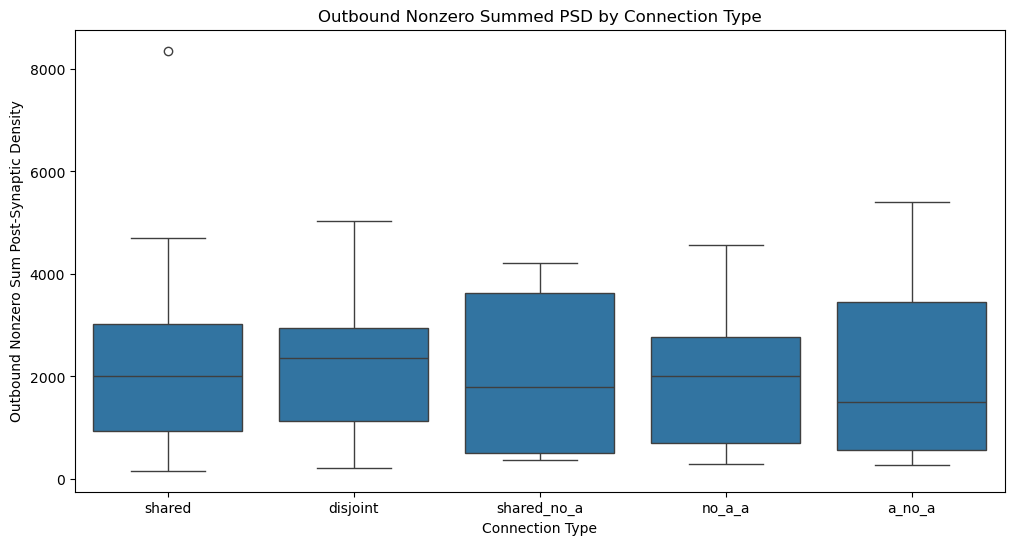

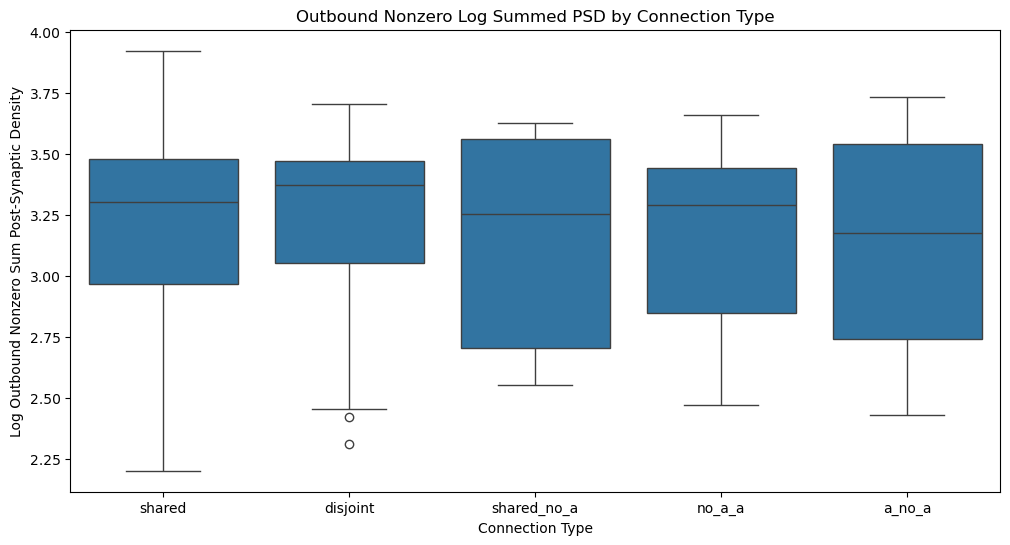

Normality Test Results (Shapiro-Wilk) for Outbound Nonzero PSD with Sample Sizes:
             Sample Size  Statistic   p-value
shared              22.0   0.932869  0.140795
disjoint            28.0   0.878709  0.003761
shared_no_a          5.0   0.881153  0.314570
no_a_a              10.0   0.919451  0.352400
a_no_a              16.0   0.913663  0.133327

Kruskal-Wallis Test on Raw Outbound Data
Statistic: 0.1191, p-value: 0.9983

ANOVA on Log-Transformed Outbound Data
             sum_sq    df        F    PR(>F)
Group      0.060849   4.0  0.08253  0.987535
Residual  14.008640  76.0      NaN       NaN


In [9]:
# Convert W_nonzero_out into a long-format DataFrame
data_out = []
for group, values in W_nonzero_out.items():
    for value in values.values():
        data_out.append({'Group': group, 'Outbound_Value': value})

W_nonzero_out_df = pd.DataFrame(data_out)

# raw values boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=W_nonzero_out_df, x='Group', y='Outbound_Value')
plt.title('Outbound Nonzero Summed PSD by Connection Type')
plt.xlabel('Connection Type')
plt.ylabel('Outbound Nonzero Sum Post-Synaptic Density')
plt.show()

# Log transform the outbound values
W_nonzero_out_df['Log_Outbound_Value'] = np.log10(W_nonzero_out_df['Outbound_Value'])

# Boxplots for log-transformed outbound nonzero PSD
plt.figure(figsize=(12, 6))
sns.boxplot(data=W_nonzero_out_df, x='Group', y='Log_Outbound_Value')
plt.title('Outbound Nonzero Log Summed PSD by Connection Type')
plt.xlabel('Connection Type')
plt.ylabel('Log Outbound Nonzero Sum Post-Synaptic Density')
plt.show()

# Tests for deviation from normality for each log-transformed group
normality_results_out = {}

for group in W_nonzero_out_df['Group'].unique():
    group_values = W_nonzero_out_df[W_nonzero_out_df['Group'] == group]['Log_Outbound_Value']
    stat, p_value = shapiro(group_values)
    sample_size = len(group_values)
    normality_results_out[group] = {'Sample Size': sample_size, 'Statistic': stat, 'p-value': p_value}

normality_results_out_df = pd.DataFrame(normality_results_out).T
print("Normality Test Results (Shapiro-Wilk) for Outbound Nonzero PSD with Sample Sizes:")
print(normality_results_out_df)

print()

groups_out_raw = [list(W_nonzero_out[group].values()) for group in W_nonzero_out.keys()]

# Perform the Kruskal-Wallis test
kruskal_stat_out, kruskal_p_value_out = kruskal(*groups_out_raw)
print("Kruskal-Wallis Test on Raw Outbound Data")
print(f"Statistic: {kruskal_stat_out:.4f}, p-value: {kruskal_p_value_out:.4f}")

# ANOVA on log data
model_out = ols('Log_Outbound_Value ~ Group', data=W_nonzero_out_df).fit()
anova_table_out = sm.stats.anova_lm(model_out, typ=2)

print("\nANOVA on Log-Transformed Outbound Data")
print(anova_table_out)

No detectable difference between groups

## Inbound

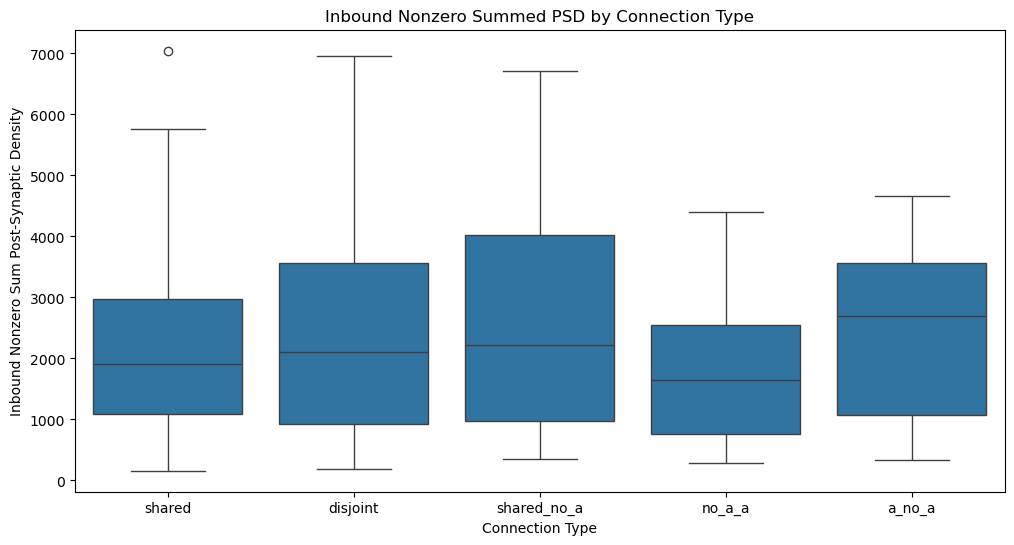

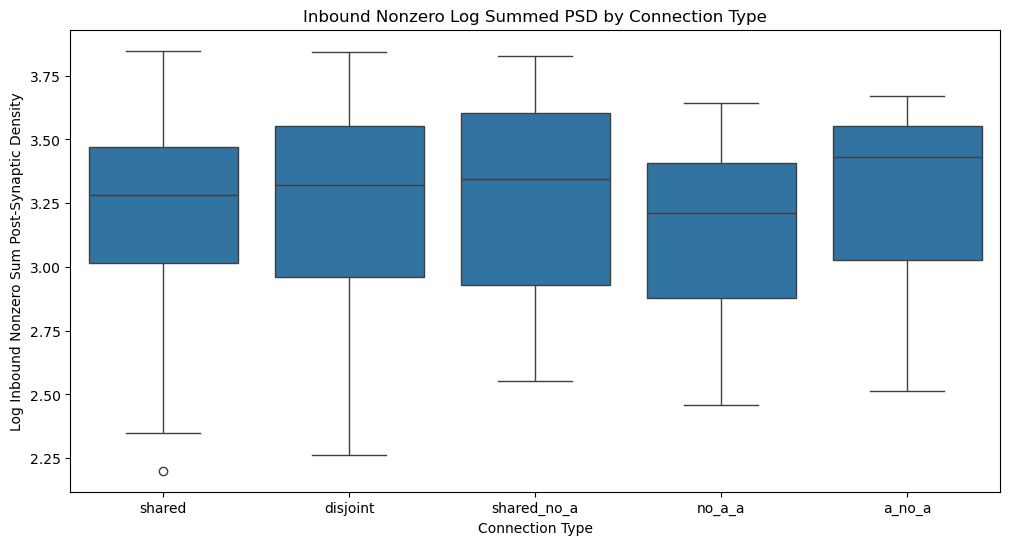

Normality Test Results (Shapiro-Wilk) for Inbound Nonzero PSD with Sample Sizes:
             Sample Size  Statistic   p-value
shared              23.0   0.922067  0.073780
disjoint            36.0   0.920261  0.012812
shared_no_a          7.0   0.931240  0.561496
no_a_a              18.0   0.934074  0.228879
a_no_a              13.0   0.873138  0.057624

Kruskal-Wallis Test on Raw Inbound Data
Statistic: 2.0008, p-value: 0.7356

ANOVA on Log-Transformed Inbound Data
             sum_sq    df         F    PR(>F)
Group      0.188595   4.0  0.259558  0.903119
Residual  16.711797  92.0       NaN       NaN


In [10]:
# Convert W_nonzero_in into a long-format DataFrame
data_in = []
for group, values in W_nonzero_in.items():
    for value in values.values():
        data_in.append({'Group': group, 'Inbound_Value': value})

W_nonzero_in_df = pd.DataFrame(data_in)

# Plot Boxplots for Raw and Log-Transformed Inbound Values

# Raw values boxplots for inbound nonzero PSD
plt.figure(figsize=(12, 6))
sns.boxplot(data=W_nonzero_in_df, x='Group', y='Inbound_Value')
plt.title('Inbound Nonzero Summed PSD by Connection Type')
plt.xlabel('Connection Type')
plt.ylabel('Inbound Nonzero Sum Post-Synaptic Density')
plt.show()

# Log transform the inbound values
W_nonzero_in_df['Log_Inbound_Value'] = np.log10(W_nonzero_in_df['Inbound_Value'])

# Boxplots for log-transformed inbound nonzero PSD
plt.figure(figsize=(12, 6))
sns.boxplot(data=W_nonzero_in_df, x='Group', y='Log_Inbound_Value')
plt.title('Inbound Nonzero Log Summed PSD by Connection Type')
plt.xlabel('Connection Type')
plt.ylabel('Log Inbound Nonzero Sum Post-Synaptic Density')
plt.show()

# Perform Shapiro-Wilk Test for Normality on Log-Transformed Values
normality_results_in = {}

for group in W_nonzero_in_df['Group'].unique():
    group_values = W_nonzero_in_df[W_nonzero_in_df['Group'] == group]['Log_Inbound_Value']
    stat, p_value = shapiro(group_values)
    sample_size = len(group_values)
    normality_results_in[group] = {'Sample Size': sample_size, 'Statistic': stat, 'p-value': p_value}

normality_results_in_df = pd.DataFrame(normality_results_in).T
print("Normality Test Results (Shapiro-Wilk) for Inbound Nonzero PSD with Sample Sizes:")
print(normality_results_in_df)

# Kruskal-Wallis Test on Raw Inbound Values
groups_in_raw = [list(W_nonzero_in[group].values()) for group in W_nonzero_in.keys()]

# Perform the Kruskal-Wallis test
kruskal_stat_in, kruskal_p_value_in = kruskal(*groups_in_raw)
print("\nKruskal-Wallis Test on Raw Inbound Data")
print(f"Statistic: {kruskal_stat_in:.4f}, p-value: {kruskal_p_value_in:.4f}")

# ANOVA on Log-Transformed Inbound Values
model_in = ols('Log_Inbound_Value ~ Group', data=W_nonzero_in_df).fit()
anova_table_in = sm.stats.anova_lm(model_in, typ=2)

print("\nANOVA on Log-Transformed Inbound Data")
print(anova_table_in)

# By Cell Probability of Connection

## Outbound

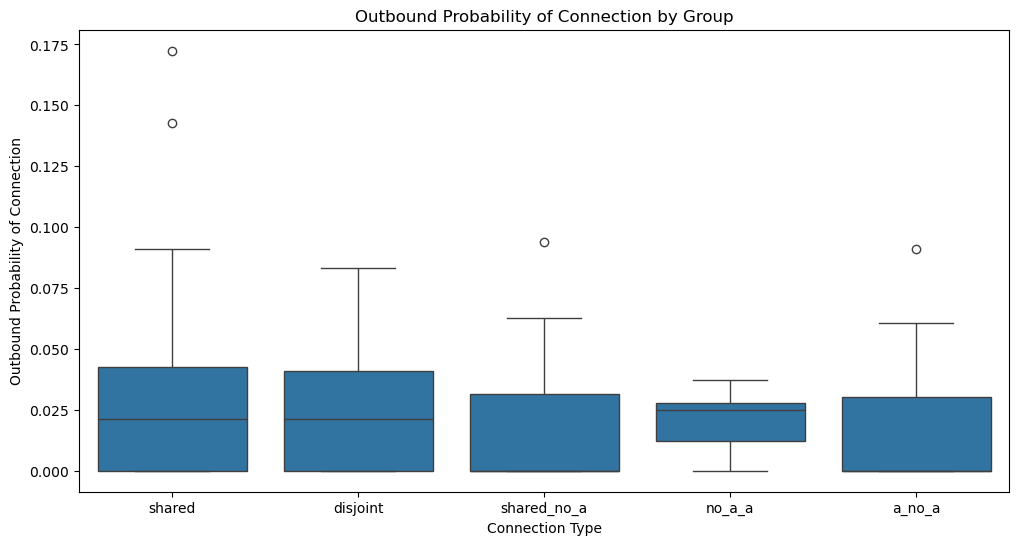

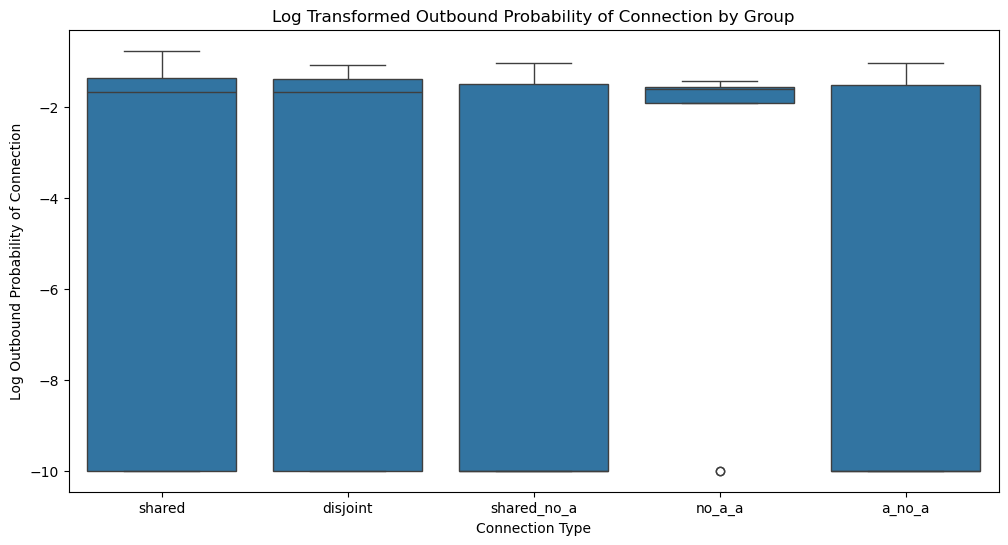

Normality Test Results (Shapiro-Wilk) for Outbound Probability of Connection with Sample Sizes:
             Sample Size  Statistic       p-value
shared              42.0   0.665947  1.637640e-08
disjoint            43.0   0.640975  5.179308e-09
shared_no_a         12.0   0.655206  3.225754e-04
no_a_a              12.0   0.504803  1.917156e-05
a_no_a              43.0   0.622087  2.720055e-09

Kruskal-Wallis Test on Raw Outbound Probabilities
Statistic: 5.8221, p-value: 0.2128

ANOVA on Log-Transformed Outbound Probabilities
               sum_sq     df         F    PR(>F)
Group      205.053520    4.0  2.940994  0.022483
Residual  2562.302764  147.0       NaN       NaN


In [11]:
# Convert B_out into a long-format DataFrame
data_out_prob = []
for group, values in B_out.items():
    for value in values.values():
        data_out_prob.append({'Group': group, 'Outbound_Probability': value})

B_out_df = pd.DataFrame(data_out_prob)

# Plot Boxplots for Raw and Log-Transformed Outbound Probabilities
plt.figure(figsize=(12, 6))
sns.boxplot(data=B_out_df, x='Group', y='Outbound_Probability')
plt.title('Outbound Probability of Connection by Group')
plt.xlabel('Connection Type')
plt.ylabel('Outbound Probability of Connection')
plt.show()

# Log transform the outbound probabilities
B_out_df['Log_Outbound_Probability'] = np.log10(B_out_df['Outbound_Probability'] + 1e-10)  # Add a small constant to avoid log(0)

plt.figure(figsize=(12, 6))
sns.boxplot(data=B_out_df, x='Group', y='Log_Outbound_Probability')
plt.title('Log Transformed Outbound Probability of Connection by Group')
plt.xlabel('Connection Type')
plt.ylabel('Log Outbound Probability of Connection')
plt.show()

# Perform Shapiro-Wilk Test for Normality on Log-Transformed Outbound Probabilities
normality_results_out_prob = {}
for group in B_out_df['Group'].unique():
    group_values = B_out_df[B_out_df['Group'] == group]['Log_Outbound_Probability']
    stat, p_value = shapiro(group_values)
    sample_size = len(group_values)
    normality_results_out_prob[group] = {'Sample Size': sample_size, 'Statistic': stat, 'p-value': p_value}

normality_results_out_prob_df = pd.DataFrame(normality_results_out_prob).T
print("Normality Test Results (Shapiro-Wilk) for Outbound Probability of Connection with Sample Sizes:")
print(normality_results_out_prob_df)

# Kruskal-Wallis Test on Raw Outbound Probabilities
groups_out_raw_prob = [list(B_out[group].values()) for group in B_out.keys()]
kruskal_stat_out_prob, kruskal_p_value_out_prob = kruskal(*groups_out_raw_prob)
print("\nKruskal-Wallis Test on Raw Outbound Probabilities")
print(f"Statistic: {kruskal_stat_out_prob:.4f}, p-value: {kruskal_p_value_out_prob:.4f}")

# ANOVA on Log-Transformed Outbound Probabilities
model_out_prob = ols('Log_Outbound_Probability ~ Group', data=B_out_df).fit()
anova_table_out_prob = sm.stats.anova_lm(model_out_prob, typ=2)
print("\nANOVA on Log-Transformed Outbound Probabilities")
print(anova_table_out_prob)

A significant but perhaps inapplicable ANOVA result. Clear deviation from normality for each group. 

## Inbound

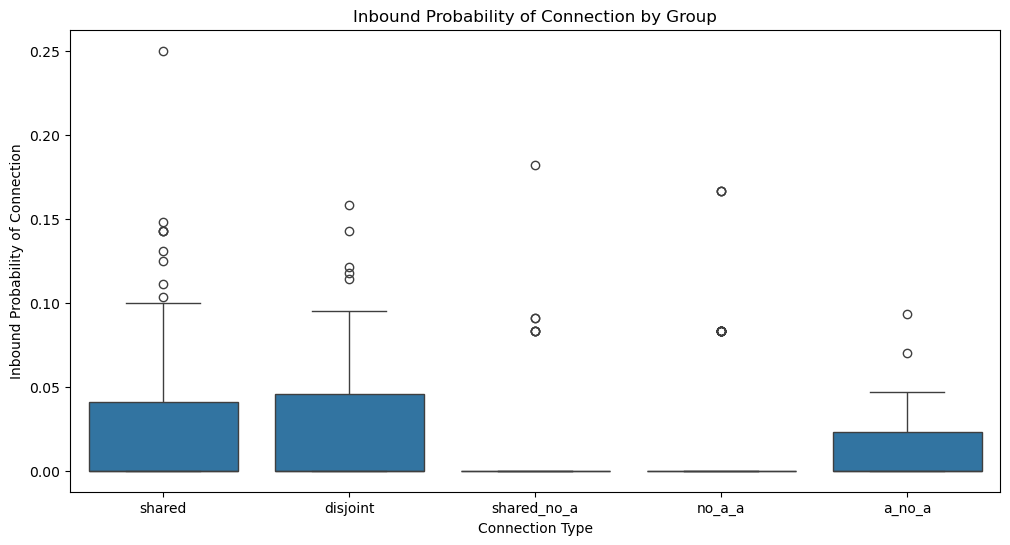

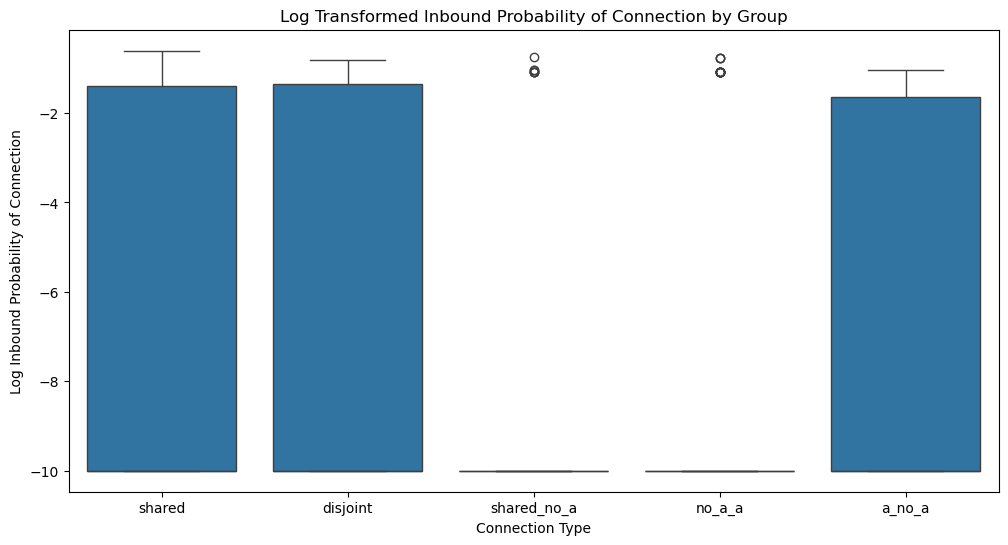


Normality Test Results (Shapiro-Wilk) for Inbound Probability of Connection with Sample Sizes:
             Sample Size  Statistic       p-value
shared              79.0   0.581245  1.143905e-13
disjoint            81.0   0.653519  1.577194e-12
shared_no_a         33.0   0.508447  2.233376e-09
no_a_a              81.0   0.516555  6.747358e-15
a_no_a              33.0   0.636451  8.094734e-08

Kruskal-Wallis Test on Raw Inbound Probabilities
Statistic: 6.1999, p-value: 0.1847

ANOVA on Log-Transformed Inbound Probabilities
               sum_sq     df         F    PR(>F)
Group      184.348616    4.0  2.812279  0.025668
Residual  4949.125037  302.0       NaN       NaN


In [12]:
# Convert B_in into a long-format DataFrame
data_in_prob = []
for group, values in B_in.items():
    for value in values.values():
        data_in_prob.append({'Group': group, 'Inbound_Probability': value})

B_in_df = pd.DataFrame(data_in_prob)

# Plot Boxplots for Raw and Log-Transformed Inbound Probabilities
plt.figure(figsize=(12, 6))
sns.boxplot(data=B_in_df, x='Group', y='Inbound_Probability')
plt.title('Inbound Probability of Connection by Group')
plt.xlabel('Connection Type')
plt.ylabel('Inbound Probability of Connection')
plt.show()

# Log transform the inbound probabilities
B_in_df['Log_Inbound_Probability'] = np.log10(B_in_df['Inbound_Probability'] + 1e-10)  # Add a small constant to avoid log(0)

plt.figure(figsize=(12, 6))
sns.boxplot(data=B_in_df, x='Group', y='Log_Inbound_Probability')
plt.title('Log Transformed Inbound Probability of Connection by Group')
plt.xlabel('Connection Type')
plt.ylabel('Log Inbound Probability of Connection')
plt.show()

# Perform Shapiro-Wilk Test for Normality on Log-Transformed Inbound Probabilities
normality_results_in_prob = {}
for group in B_in_df['Group'].unique():
    group_values = B_in_df[B_in_df['Group'] == group]['Log_Inbound_Probability']
    stat, p_value = shapiro(group_values)
    sample_size = len(group_values)
    normality_results_in_prob[group] = {'Sample Size': sample_size, 'Statistic': stat, 'p-value': p_value}

normality_results_in_prob_df = pd.DataFrame(normality_results_in_prob).T
print("\nNormality Test Results (Shapiro-Wilk) for Inbound Probability of Connection with Sample Sizes:")
print(normality_results_in_prob_df)

# Kruskal-Wallis Test on Raw Inbound Probabilities
groups_in_raw_prob = [list(B_in[group].values()) for group in B_in.keys()]
kruskal_stat_in_prob, kruskal_p_value_in_prob = kruskal(*groups_in_raw_prob)
print("\nKruskal-Wallis Test on Raw Inbound Probabilities")
print(f"Statistic: {kruskal_stat_in_prob:.4f}, p-value: {kruskal_p_value_in_prob:.4f}")

# ANOVA on Log-Transformed Inbound Probabilities
model_in_prob = ols('Log_Inbound_Probability ~ Group', data=B_in_df).fit()
anova_table_in_prob = sm.stats.anova_lm(model_in_prob, typ=2)
print("\nANOVA on Log-Transformed Inbound Probabilities")
print(anova_table_in_prob)

A significant but perhaps inapplicable ANOVA result. Clear deviation from normality for each group. 